In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from natsort import natsorted

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50V2, Xception
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train1_dataset_path='C:\\Users\FreeComp\\3D Objects\\MachineLearningCourse-main\\train_Images_Source_1'
train2_dataset_path='C:\\Users\FreeComp\\3D Objects\\MachineLearningCourse-main\\train_Images_Source_2'


In [4]:
dataset = []
for category in os.listdir(train1_dataset_path):
    category_path = os.path.join(train1_dataset_path, category)
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            dataset.append((image_path, category))

In [5]:
for image_file in os.listdir(train2_dataset_path):
    category = image_file.split('_')[0]  # Extract category from the image file name
    image_path = os.path.join(train2_dataset_path, image_file)
    dataset.append((image_path, category))


In [6]:
import random
random.shuffle(dataset)


In [7]:
train_ratio = 0.8  # Adjust as needed
train_size = int(len(dataset) * train_ratio)

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:]

In [8]:
train_path = "data/all_train_over/"
val_path = "data/all_val_over/"
import shutil
for image_path, category in train_dataset:
    category_folder = os.path.join(train_path, category)
    os.makedirs(category_folder, exist_ok=True)
    shutil.copy(image_path, category_folder)

for image_path, category in val_dataset:
    category_folder = os.path.join(val_path, category)
    os.makedirs(category_folder, exist_ok=True)
    shutil.copy(image_path, category_folder)

In [9]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [10]:
train_datagen = ImageDataGenerator(
    #rotation_range=20,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 10091 images belonging to 15 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)
validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3789 images belonging to 15 classes.


In [12]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Ascariasis
1 : Babesia
2 : Capillaria p
3 : Enterobius v
4 : Epidermophyton floccosum
5 : Fasciolopsis buski
6 : Hookworm egg
7 : Hymenolepis diminuta
8 : Hymenolepis nana
9 : Leishmania
10 : Opisthorchis viverrine
11 : Paragonimus spp
12 : T. rubrum
13 : Taenia spp
14 : Trichuris trichiura


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


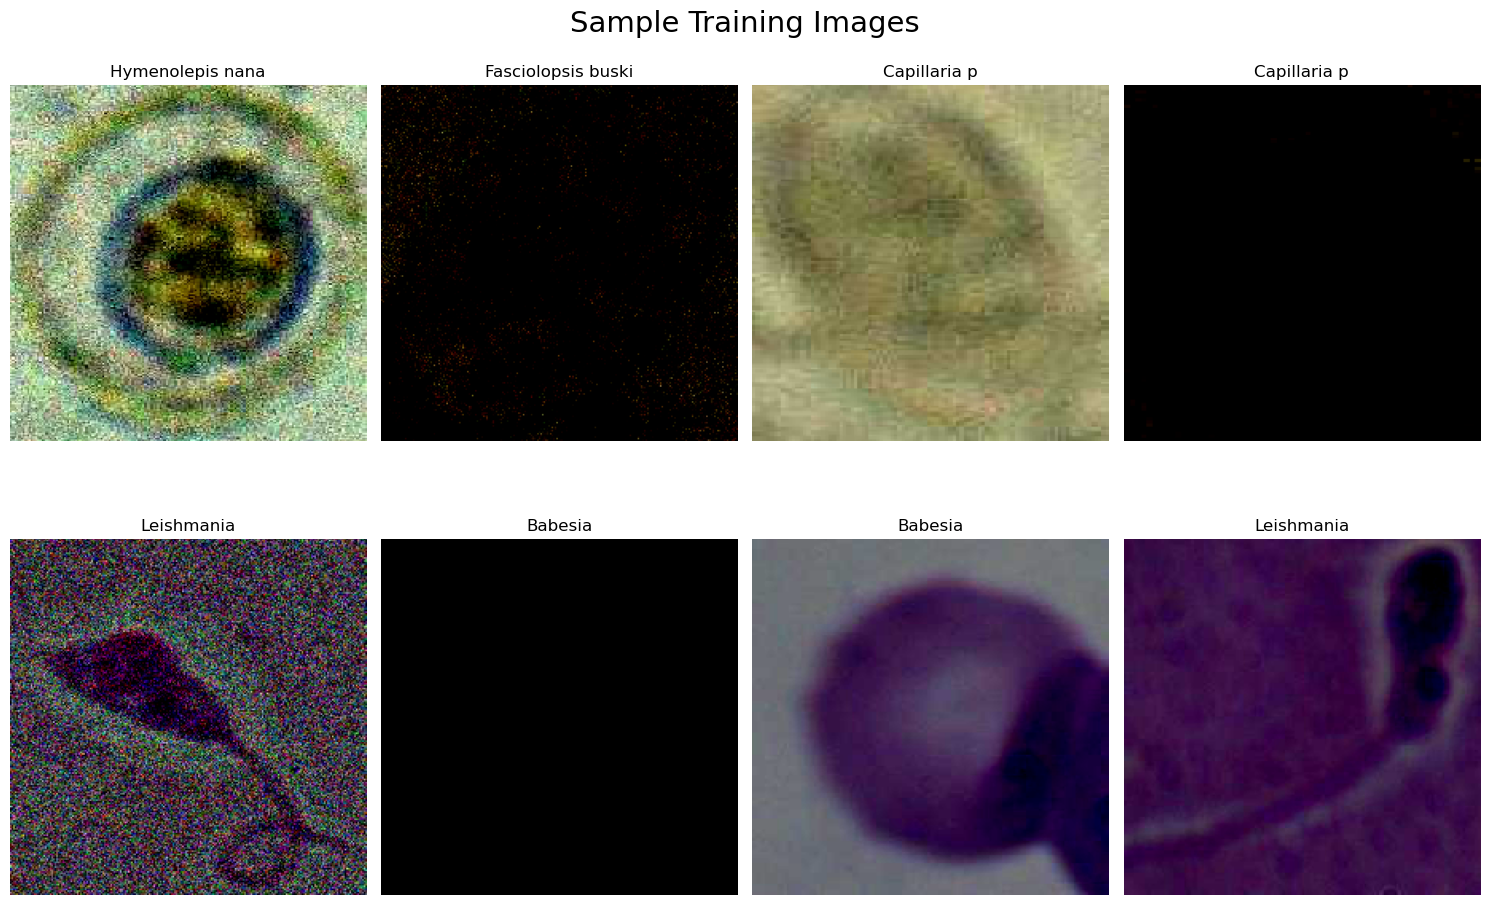

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [22]:
resnet_model = Sequential()

pretrained_model= ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling='avg',
    classes=15
)

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(BatchNormalization())

resnet_model.add(Flatten())

resnet_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))

resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(15, activation='softmax'))

94668760/94668760 [==============================] - 182s 2us/step


In [24]:
print(resnet_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                      

In [25]:
resnet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=EarlyStopping(
        monitor='val_loss',  
        patience=2,      
        restore_best_weights=True  
    ),
    verbose=1
)

Epoch 1/5
263/263 [==============================] - 657s 2s/step - loss: 1.5555 - accuracy: 0.7681 - val_loss: 1.1183 - val_accuracy: 0.8692
Epoch 2/5
263/263 [==============================] - 600s 2s/step - loss: 1.0696 - accuracy: 0.8766 - val_loss: 1.0454 - val_accuracy: 0.8815
Epoch 3/5
263/263 [==============================] - 598s 2s/step - loss: 0.9347 - accuracy: 0.9005 - val_loss: 0.9769 - val_accuracy: 0.8901
Epoch 4/5
263/263 [==============================] - 542s 2s/step - loss: 0.8252 - accuracy: 0.9150 - val_loss: 0.9220 - val_accuracy: 0.8853
Epoch 5/5
263/263 [==============================] - 505s 2s/step - loss: 0.7368 - accuracy: 0.9269 - val_loss: 0.8933 - val_accuracy: 0.8844


In [27]:
history = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=EarlyStopping(
        monitor='val_loss',  
        patience=2,      
        restore_best_weights=True  
    ),
    verbose=1
)

Epoch 1/5
263/263 [==============================] - 499s 2s/step - loss: 0.7590 - accuracy: 0.9185 - val_loss: 0.8986 - val_accuracy: 0.8892
Epoch 2/5
263/263 [==============================] - 726s 3s/step - loss: 0.7536 - accuracy: 0.9180 - val_loss: 0.8471 - val_accuracy: 0.9020
Epoch 3/5
263/263 [==============================] - 511s 2s/step - loss: 0.7022 - accuracy: 0.9293 - val_loss: 0.8942 - val_accuracy: 0.8901
Epoch 4/5
263/263 [==============================] - 503s 2s/step - loss: 0.7031 - accuracy: 0.9286 - val_loss: 0.9282 - val_accuracy: 0.8892


In [28]:
history = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=EarlyStopping(
        monitor='val_loss',  
        patience=2,      
        restore_best_weights=True  
    ),
    verbose=1
)

Epoch 1/5
263/263 [==============================] - 501s 2s/step - loss: 0.7131 - accuracy: 0.9253 - val_loss: 0.8966 - val_accuracy: 0.8820
Epoch 2/5
263/263 [==============================] - 501s 2s/step - loss: 0.7099 - accuracy: 0.9260 - val_loss: 0.8110 - val_accuracy: 0.8996
Epoch 3/5
263/263 [==============================] - 508s 2s/step - loss: 0.7248 - accuracy: 0.9227 - val_loss: 0.8954 - val_accuracy: 0.8939
Epoch 4/5
263/263 [==============================] - 516s 2s/step - loss: 0.7724 - accuracy: 0.9174 - val_loss: 0.8895 - val_accuracy: 0.8934


In [31]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

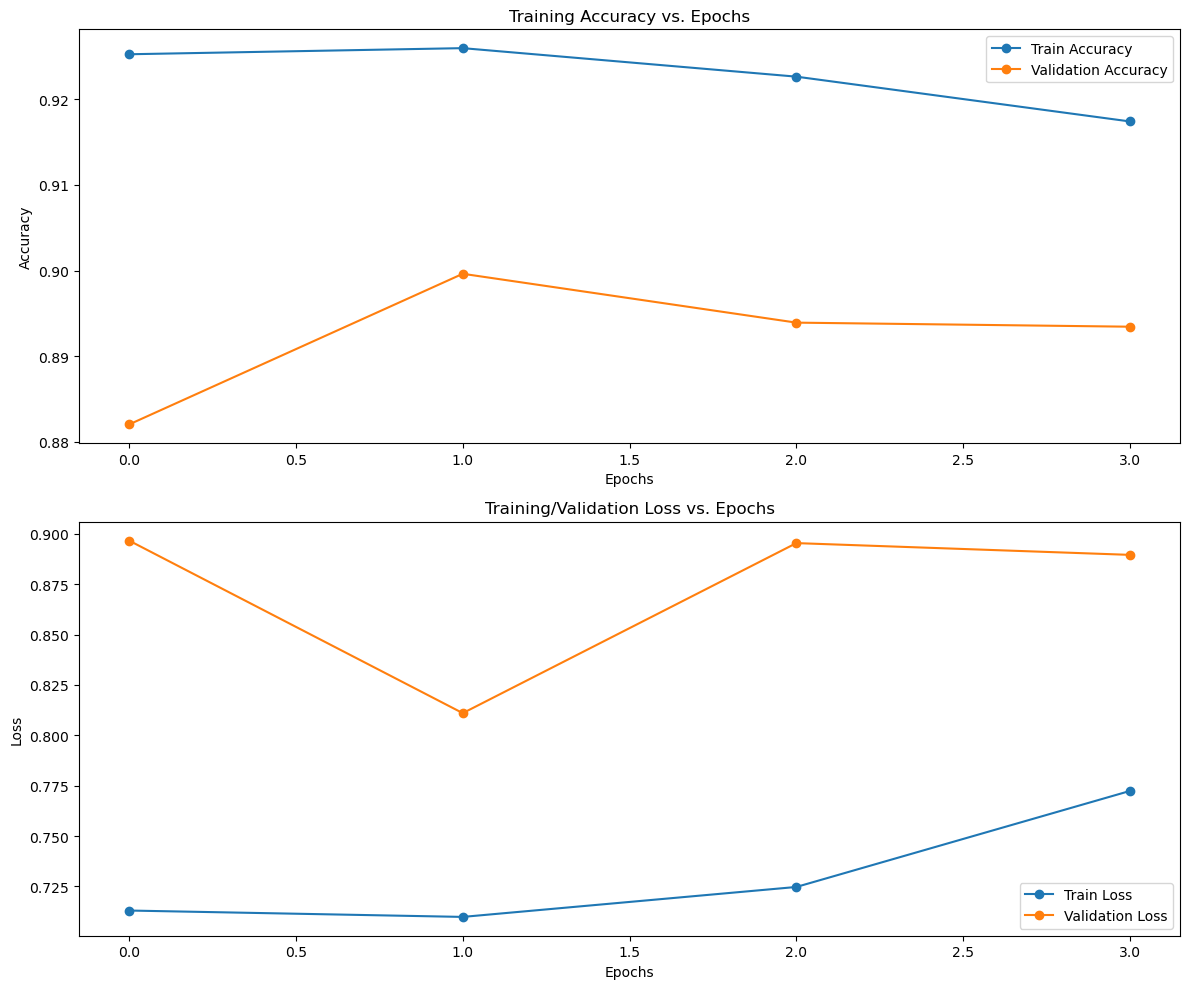

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('data/ResNet50V2 Evaluation.jpg', dpi=300, format='jpg')
plt.show()

In [34]:
resnet_model.save(f'models/ResNet50V2-{round(max(train_accuracy), 4)}ACC-{round(min(train_loss), 4)}LOSS.h5')

E:\ana\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Submission

In [43]:
test_data_dir = 'C:\\Users\FreeComp\\3D Objects\\MachineLearningCourse-main\\test_data'

test_image_files = natsorted([os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir) if file.endswith(('jpg', 'jpeg', 'png'))])
predictions = []

for image_path in test_image_files:
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

    prediction = resnet_model.predict(img_array)
    predictions.append(prediction[0])  

predictions = np.array(predictions)

submission_df = pd.DataFrame(predictions, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14'])

submission_df['image_name'] = [os.path.basename(file) for file in test_image_files]
submission_df = submission_df[['image_name', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14']]

1/1 [==============================] - 1s 1s/step


KeyboardInterrupt: 

In [ ]:
submission_df.to_csv('data/ResNet_Submission.csv', index=False)

## Xception

In [ ]:
xtrain_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)
xtrain_generator = xtrain_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

In [ ]:
xvalidation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)
xvalidation_generator = xvalidation_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

In [ ]:
labels = {value: key for key, value in xtrain_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(xtrain_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(xtrain_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [ ]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling='avg',
    classes=15
)

for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(15, activation='softmax'))

In [ ]:
print(xception_model.summary())

In [ ]:
xception_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
xhistory = xception_model.fit(
    xtrain_generator,
    validation_data=xvalidation_generator,
    callbacks=EarlyStopping(
        monitor='val_loss',  
        patience=3,      
        restore_best_weights=True  
    ),
    epochs=5
)

In [ ]:
xtrain_accuracy = xhistory.history['accuracy']
xval_accuracy = xhistory.history['val_accuracy']

xtrain_loss = xhistory.history['loss']
xval_loss = xhistory.history['val_loss']

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(xtrain_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(xval_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(xtrain_loss, 'o-', label='Train Loss')
ax[1].plot(xval_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('images/Xception Evaluation.jpg', dpi=300, format='jpg')
plt.show()

In [ ]:
xception_model.save(f'models/XCEPTION-{round(max(xtrain_accuracy), 4)}ACC-{round(min(xtrain_loss), 4)}LOSS.h5')

## Submission

In [ ]:
test_data_dir = 'data/test_data'

test_image_files = natsorted([os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir) if file.endswith(('jpg', 'jpeg', 'png'))])
predictions = []

for image_path in test_image_files:
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    img_array = tf.keras.applications.xception.preprocess_input(img_array)

    prediction = xception_model.predict(img_array)
    predictions.append(prediction[0])  

predictions = np.array(predictions)

submission_df = pd.DataFrame(predictions, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14'])

submission_df['image_name'] = [os.path.basename(file) for file in test_image_files]
submission_df = submission_df[['image_name', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14']]

In [ ]:
submission_df.to_csv('data/Xception_Submission.csv', index=False)

In [ ]:
#Resnet50V

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [15]:
tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


102869336/102869336 [==============================] - 63s 1us/step


In [18]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Create an ImageDataGenerator for validation data
xvalidation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)
xtrain_generator = xvalidation_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Evaluate the model on the validation data
##validation_loss, validation_accuracy = model.evaluate_generator(xvalidation_generator)

# Print the validation accuracy
#print(f'Validation Accuracy: {validation_accuracy*100:.2f}%')

Found 3789 images belonging to 15 classes.


In [19]:
labels = {value: key for key, value in xtrain_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Ascariasis
1 : Babesia
2 : Capillaria p
3 : Enterobius v
4 : Epidermophyton floccosum
5 : Fasciolopsis buski
6 : Hookworm egg
7 : Hymenolepis diminuta
8 : Hymenolepis nana
9 : Leishmania
10 : Opisthorchis viverrine
11 : Paragonimus spp
12 : T. rubrum
13 : Taenia spp
14 : Trichuris trichiura


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


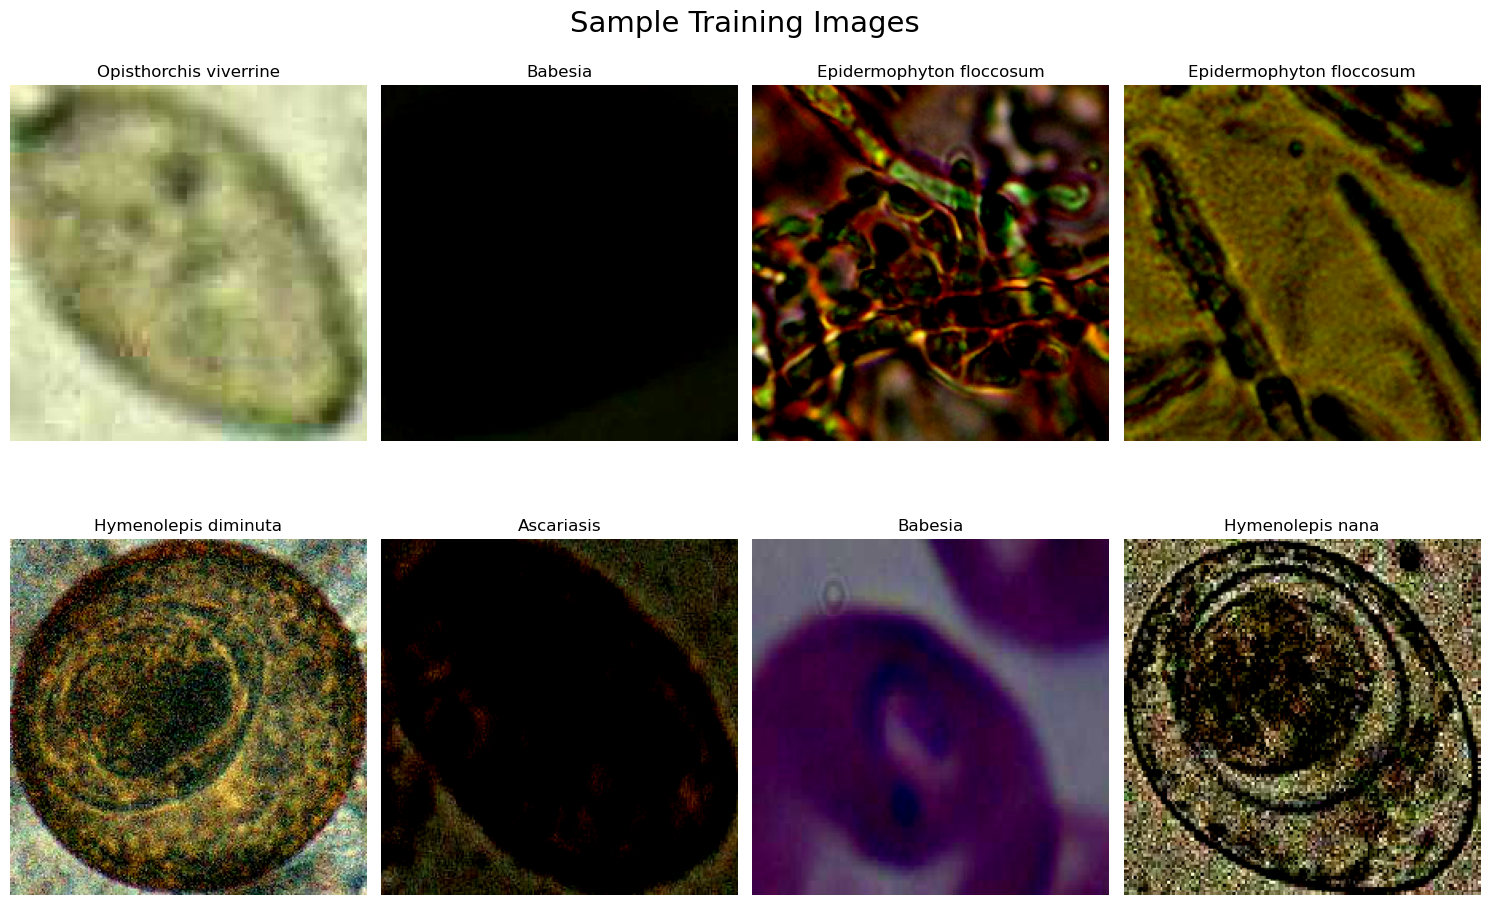

In [20]:
import numpy as np
import matplotlib.pyplot as plt

nrows, ncols = 2, 4

# Create a figure and axes for the grid
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Initialize the index
idx = 0

# Iterate over the grid
for i in range(nrows):
    for j in range(ncols):
        # Get the label for the current image
        label = labels[np.argmax(xtrain_generator[0][1][idx])]
        
        # Set the title and display the image
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(xtrain_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        
        # Increment the index
        idx += 1

# Adjust the layout and add a title
plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)

# Show the plot
plt.show()

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    pooling='avg'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(15, activation='softmax'))

In [22]:
print(resnet_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 24621583 (93.92 MB)
Trainable params: 1056783 (4.03 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________
None


In [23]:
resnet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
xhistory = resnet_model.fit(
    xtrain_generator,
    validation_data=xvalidation_generator,
    callbacks=EarlyStopping(
        monitor='val_loss',  
        patience=3,      
        restore_best_weights=True  
    ),
    epochs=5
)

Epoch 1/5
119/119 [==============================] - 432s 4s/step - loss: 0.7531 - accuracy: 0.7598 - val_loss: 0.2876 - val_accuracy: 0.9113
Epoch 2/5
119/119 [==============================] - 419s 4s/step - loss: 0.2619 - accuracy: 0.9095 - val_loss: 0.1196 - val_accuracy: 0.9652
Epoch 3/5
119/119 [==============================] - 413s 3s/step - loss: 0.1327 - accuracy: 0.9567 - val_loss: 0.0934 - val_accuracy: 0.9781
Epoch 4/5
119/119 [==============================] - 410s 3s/step - loss: 0.0804 - accuracy: 0.9770 - val_loss: 0.0440 - val_accuracy: 0.9889
Epoch 5/5
119/119 [==============================] - 418s 4s/step - loss: 0.0472 - accuracy: 0.9900 - val_loss: 0.0288 - val_accuracy: 0.9958


In [27]:
xtrain_accuracy = xhistory.history['accuracy']
xval_accuracy = xhistory.history['val_accuracy']

xtrain_loss = xhistory.history['loss']
xval_loss = xhistory.history['val_loss']

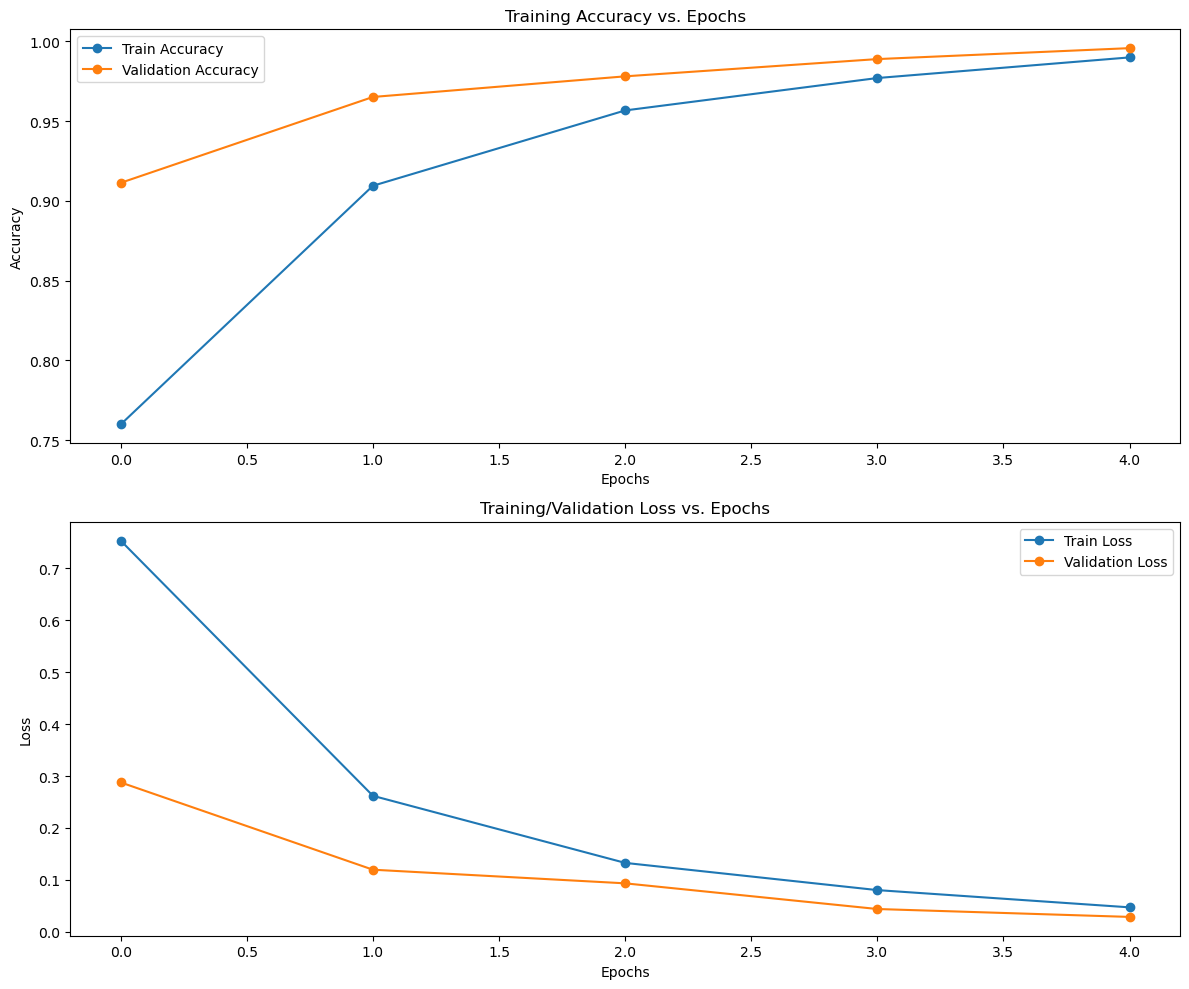

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(xtrain_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(xval_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(xtrain_loss, 'o-', label='Train Loss')
ax[1].plot(xval_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('data/ressnet Evaluation.jpg', dpi=300, format='jpg')
plt.show()

In [33]:
resnet_model.save(f'models/resnet-{round(max(xtrain_accuracy), 4)}ACC-{round(min(xtrain_loss), 4)}LOSS.h5')

In [38]:
pip install keras-applications


     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     ------------------------ --------------- 30.7/50.7 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 50.7/50.7 kB 652.6 kB/s eta 0:00:00


In [40]:
from keras_applications.resnet import ResNet50

In [41]:
##error with me
test_data_dir = 'C:\\Users\FreeComp\\3D Objects\\MachineLearningCourse-main\\test_data'

test_image_files = natsorted([os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir) if file.endswith(('jpg', 'jpeg', 'png'))])
predictions = []

for image_path in test_image_files:
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    img_array = tf.keras.applications.resnet_model.preprocess_input(img_array)

    prediction = resnet_model.predict(img_array)
    predictions.append(prediction[0])  

predictions = np.array(predictions)

submission_df = pd.DataFrame(predictions, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14'])

submission_df['image_name'] = [os.path.basename(file) for file in test_image_files]
submission_df = submission_df[['image_name', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14']]

AttributeError: module 'tensorflow.keras.applications' has no attribute 'resnet_model'

In [ ]:
from keras.applications.resnet import preprocess_input
from keras.applications.resnet import ResNet50

In [ ]:
test_data_dir = 'C:\\Users\FreeComp\\3D Objects\\MachineLearningCourse-main\\test_data'

test_image_files = natsorted([os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir) if file.endswith(('jpg', 'jpeg', 'png'))])
predictions = []

for image_path in test_image_files:
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 

    img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

    prediction = resnet_model.predict(img_array)
    predictions.append(prediction[0])  

predictions = np.array(predictions)

submission_df = pd.DataFrame(predictions, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14'])

submission_df['image_name'] = [os.path.basename(file) for file in test_image_files]
submission_df = submission_df[['image_name', 'class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14']]

1/1 [==============================] - 1s 799ms/step


In [ ]:
submission_df.to_csv('resnet50V.csv', index=False)

In [ ]:
submission_df.head(10)